In [1]:
import pickle
X_hr,y_stress,y_participant,X_time = pickle.load(open('../data/tabular_data_60_seconds_ppg_rr.p','rb'))

X_hr = X_hr.reshape(-1,30,1)

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer,LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

train_participant = y_participant.copy()

print(np.unique(y_participant),train_participant.shape)

n_classes = len(np.unique(y_participant))
n_classes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] (42928,)


15

In [2]:
train_x = X_hr
train_y = y_participant

train_x, test_x, train_y, test_y,participant_ids_train, participant_ids_test = train_test_split(X_hr,
                                                            train_participant,
                                                            y_participant,
                                                            test_size = 0.5,
                                                            random_state=41,
                                                            stratify=y_participant)
train_x, val_x, train_y, val_y, participant_ids_train, participant_ids_val  = train_test_split(train_x,
                                                            train_y,
                                                            participant_ids_train,
                                                            test_size = 0.1,
                                                            random_state=41,
                                                            stratify=participant_ids_train)
train_x.shape,test_x.shape,val_x.shape,train_y.shape,test_y.shape,val_y.shape,participant_ids_train.shape

def get_model(input_shape=(30,1),act='relu',loss="sparse_categorical_crossentropy",opt='adam',n_classes=350):
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='linear',kernel_initializer='normal',padding='same'))
    model.add(Conv1D(100,10,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(300,10,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Conv1D(50,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Flatten())
    model.add(Dense(n_classes*2,activation=None))
    model.add(Dense(n_classes,activation=None))
    model.add(tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
    model.add(Dense(n_classes,activation='softmax',kernel_initializer='normal'))
    model.compile(loss=loss,optimizer=opt,metrics=['acc'])
    return model

model = get_model(input_shape=(30,1),n_classes=n_classes)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 100)           1100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 30, 100)           100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 100)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 100)           400       
_________________________________________________________________
dropout (Dropout)            (None, 15, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 200)           2

In [3]:
from keras.models import load_model
filepath = '../model_files/base_cnn_60_seconds_ppg_hr_wesad_ig.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=400, batch_size=200,
          callbacks=callbacks_list,shuffle=True)

model = load_model(filepath)
train_embeddings = model.predict(train_x)

Epoch 1/400
97/97 [==============================] - ETA: 0s - loss: 2.6172 - acc: 0.1839
Epoch 00001: val_loss improved from inf to 2.72793, saving model to ../model_files/base_cnn_60_seconds_ppg_hr_wesad_ig.hdf5
97/97 [==============================] - 1s 15ms/step - loss: 2.6172 - acc: 0.1839 - val_loss: 2.7279 - val_acc: 0.0810
Epoch 2/400
97/97 [==============================] - ETA: 0s - loss: 2.5150 - acc: 0.2042
Epoch 00002: val_loss improved from 2.72793 to 2.70105, saving model to ../model_files/base_cnn_60_seconds_ppg_hr_wesad_ig.hdf5
97/97 [==============================] - 1s 11ms/step - loss: 2.5150 - acc: 0.2042 - val_loss: 2.7011 - val_acc: 0.1192
Epoch 3/400
93/97 [===========================>..] - ETA: 0s - loss: 2.4513 - acc: 0.2099
Epoch 00003: val_loss improved from 2.70105 to 2.64851, saving model to ../model_files/base_cnn_60_seconds_ppg_hr_wesad_ig.hdf5
97/97 [==============================] - 1s 11ms/step - loss: 2.4512 - acc: 0.2090 - val_loss: 2.6485 - val_ac

In [26]:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import numpy as np
import os
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt

In [27]:
model(test_x).numpy().argmax(axis=1)

array([ 7,  0,  1, ...,  5, 14, 14])

In [28]:
n_steps = 50
method = "gausslegendre"
internal_batch_size = 100
nb_samples = 100
ig  = IntegratedGradients(model,
                          layer=model.layers[1],
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

x_test_sample = test_x[:nb_samples]
predictions = model(x_test_sample).numpy().argmax(axis=1)

In [29]:
explanation = ig.explain(x_test_sample,
                         baselines=None,
                         target=predictions)

In [30]:
attrs = explanation.attributions
print('Attributions shape:', attrs.shape)

Attributions shape: (100, 30, 100)


In [31]:
attrs = attrs.sum(axis=2)
print('Attributions shape:', attrs.shape)

Attributions shape: (100, 30)


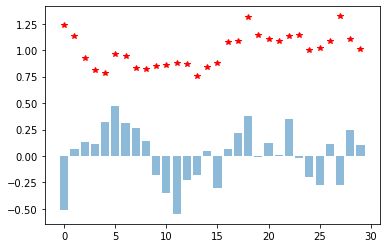

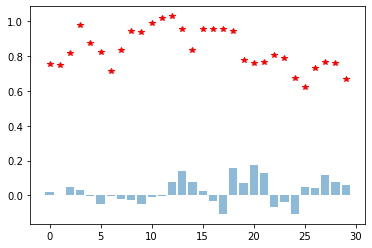

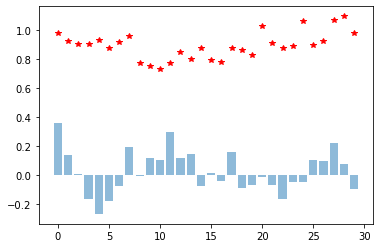

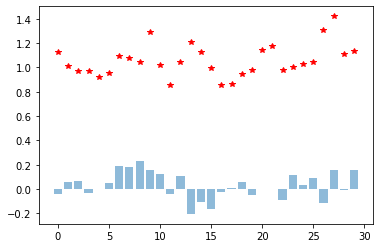

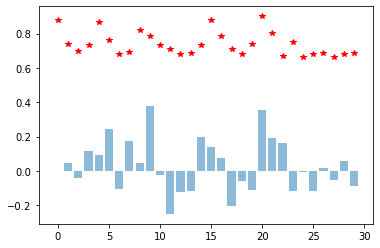

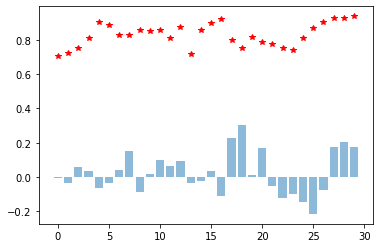

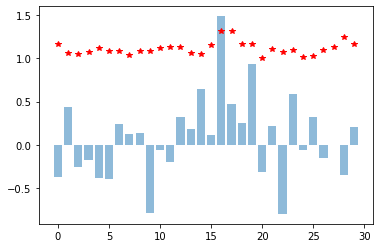

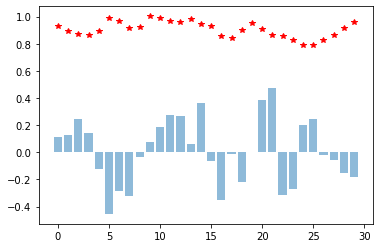

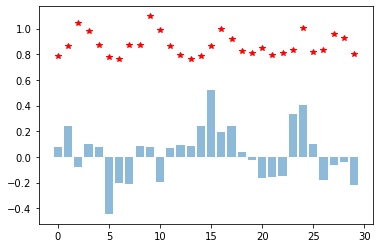

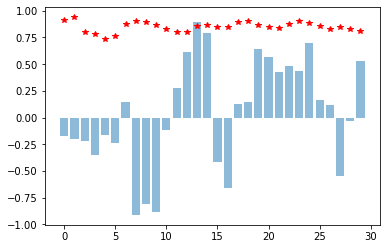

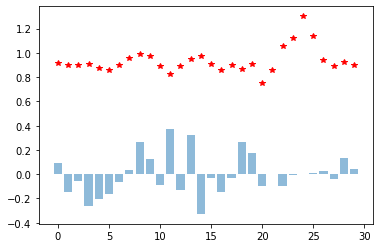

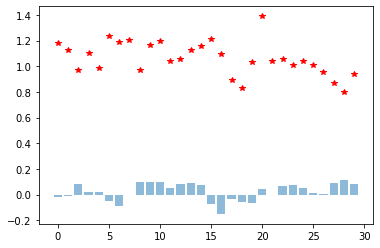

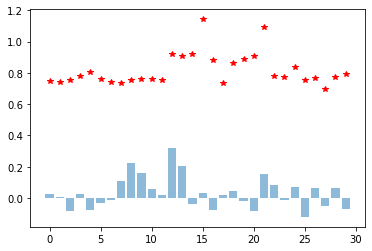

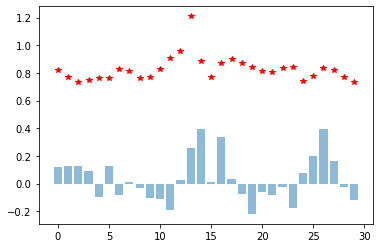

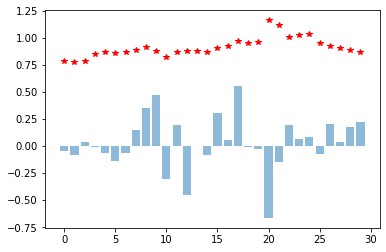

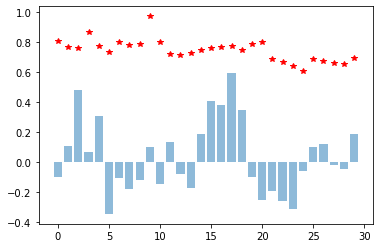

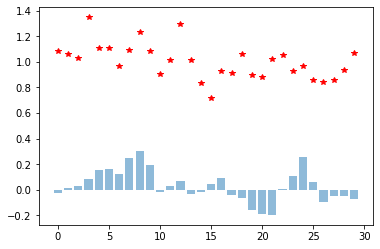

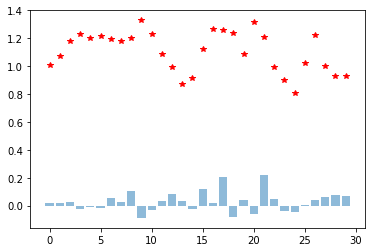

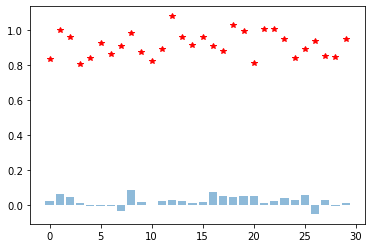

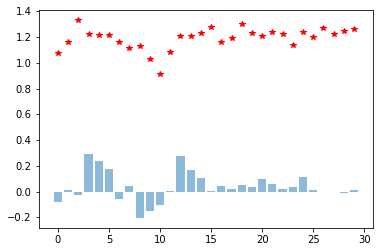

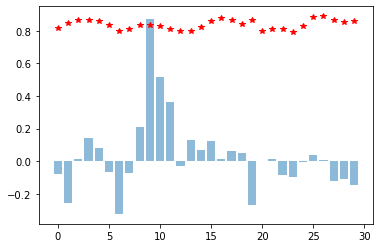

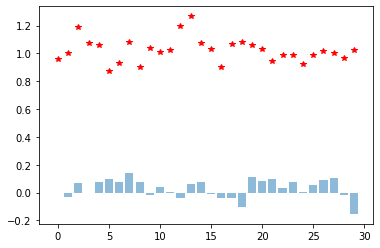

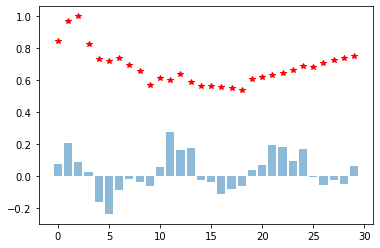

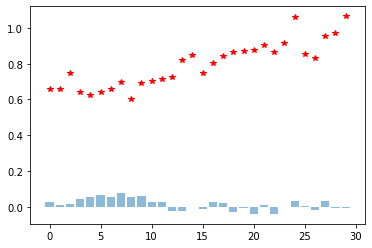

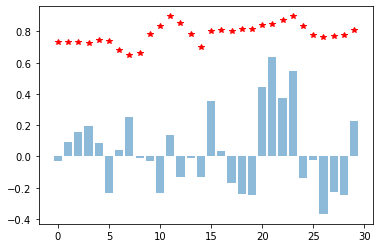

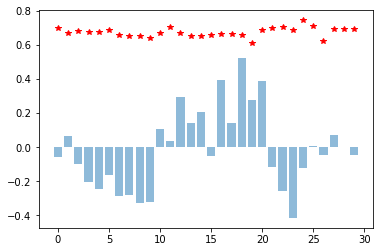

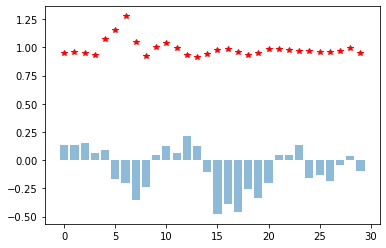

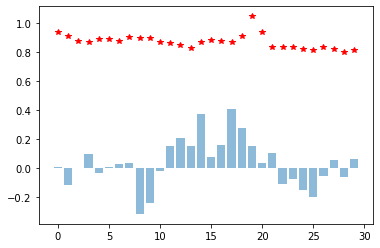

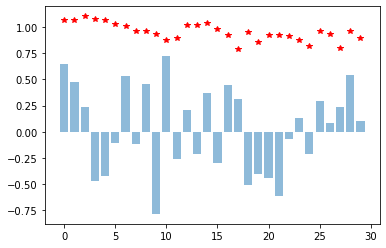

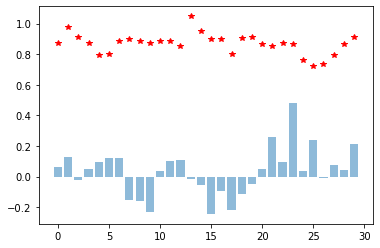

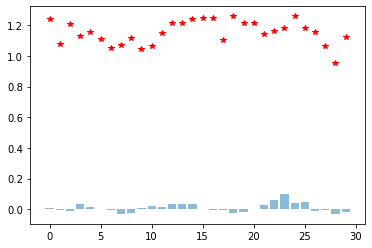

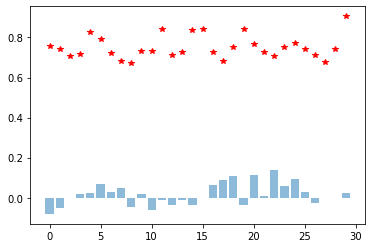

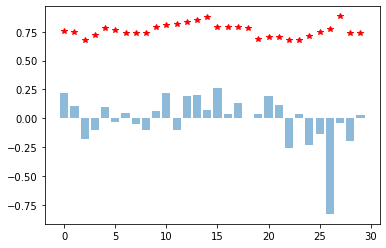

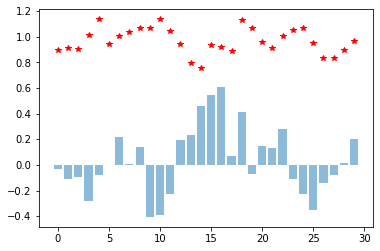

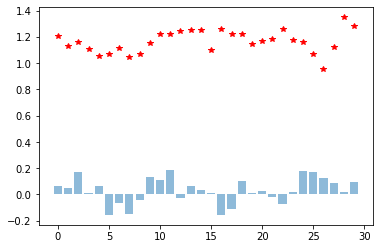

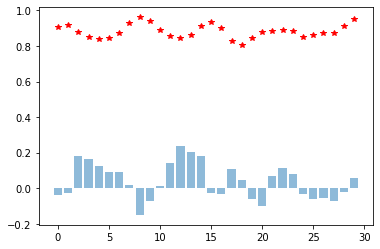

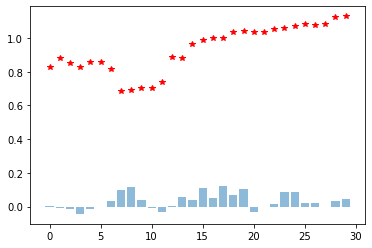

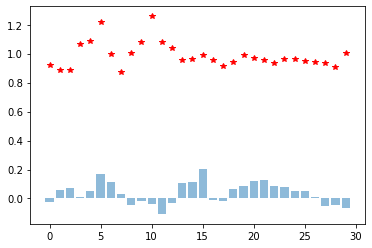

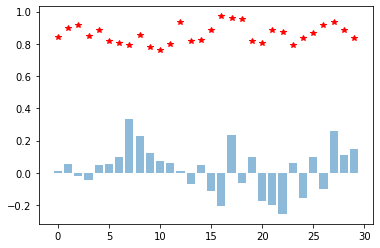

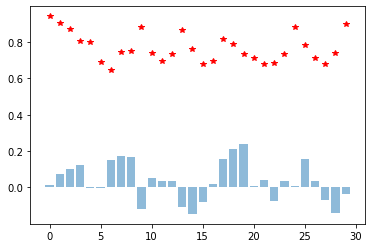

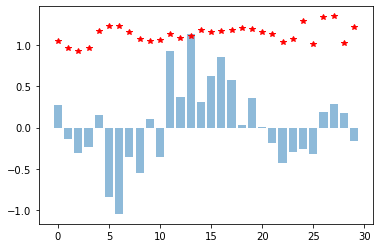

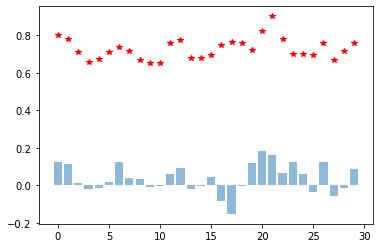

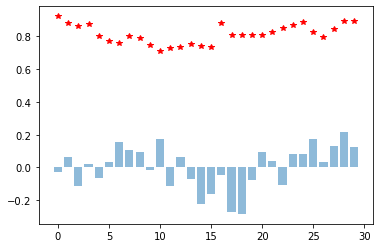

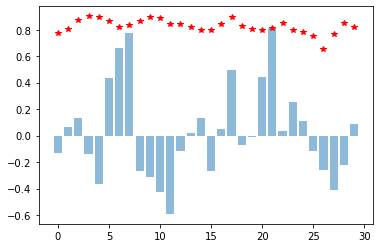

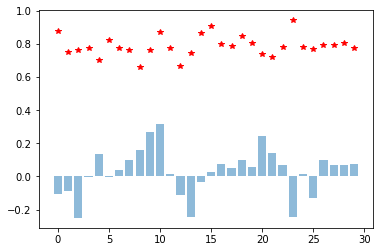

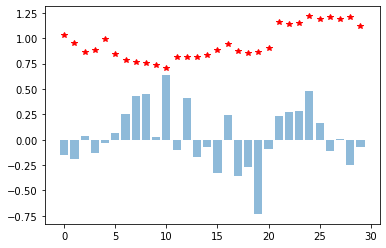

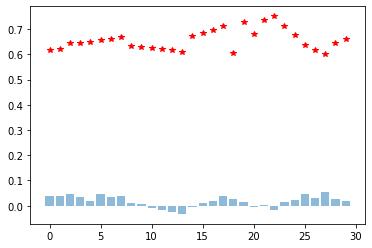

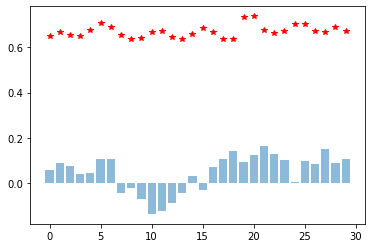

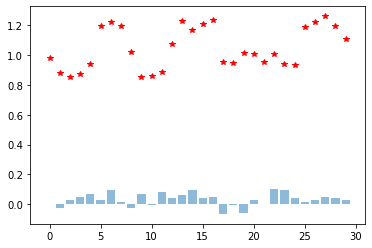

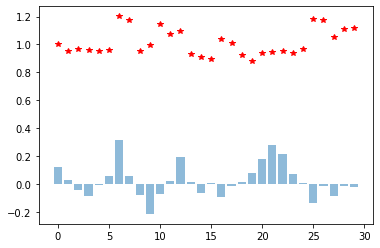

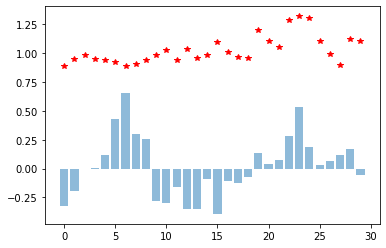

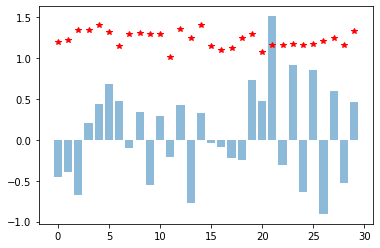

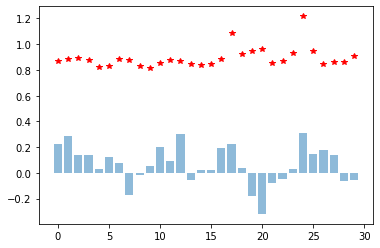

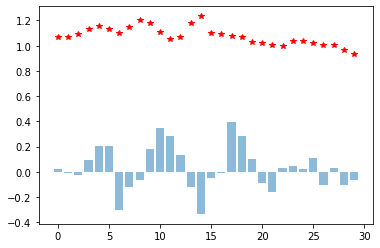

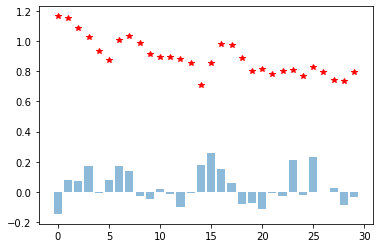

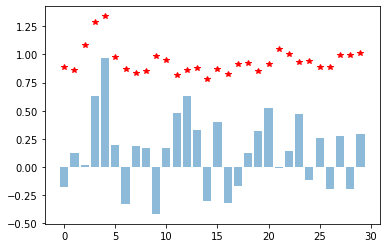

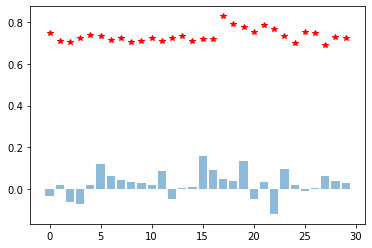

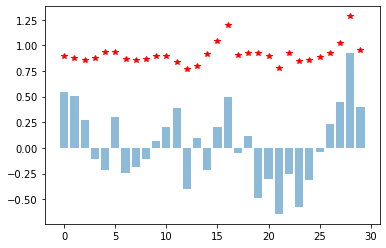

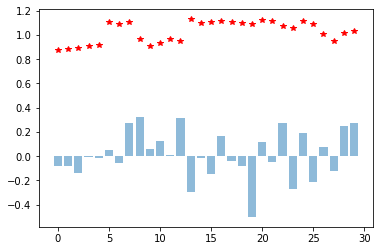

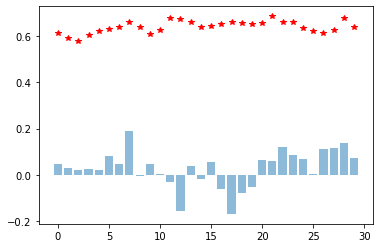

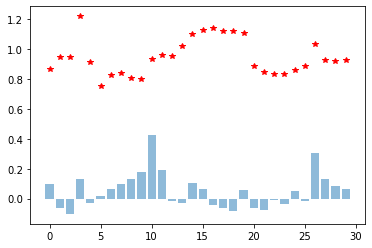

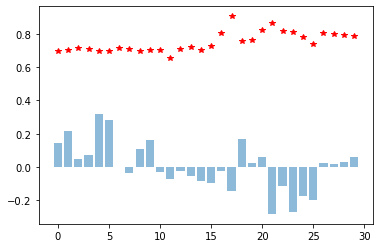

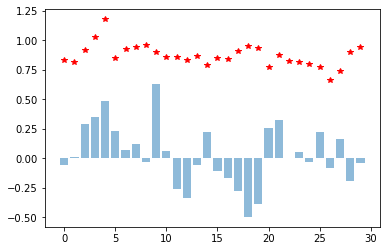

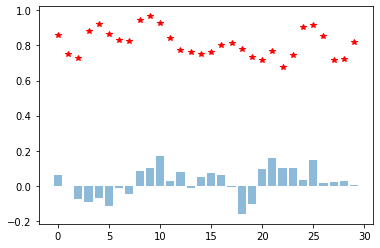

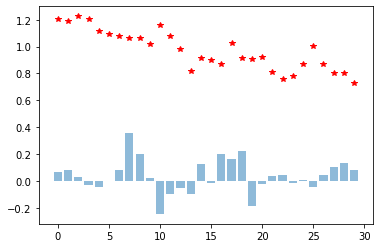

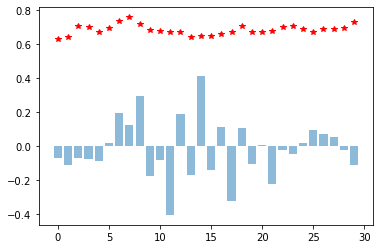

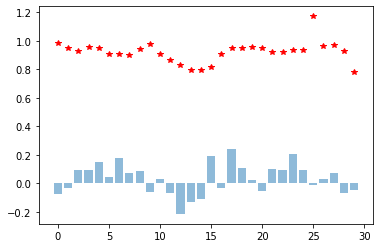

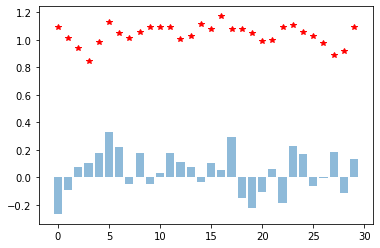

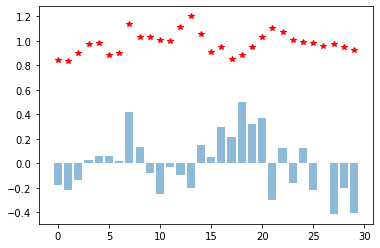

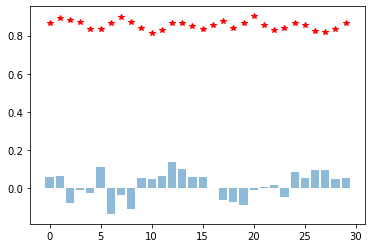

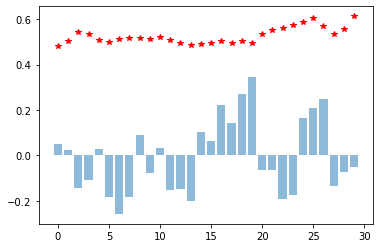

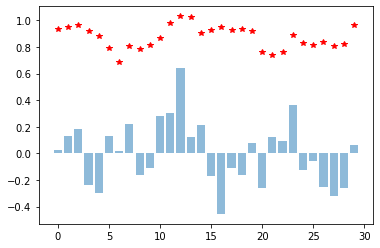

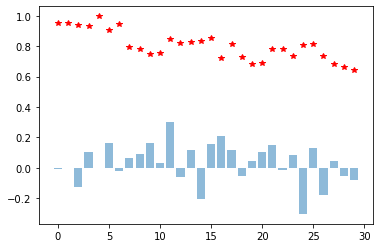

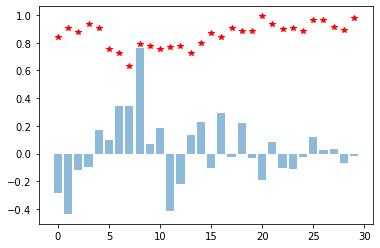

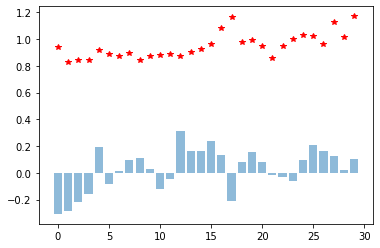

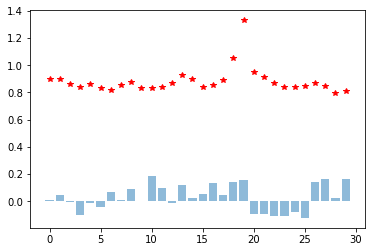

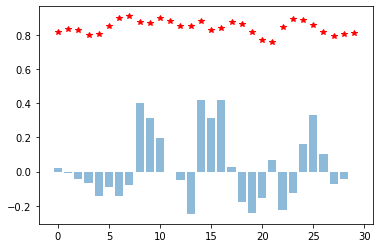

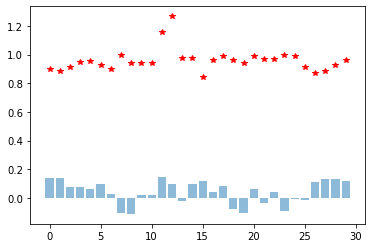

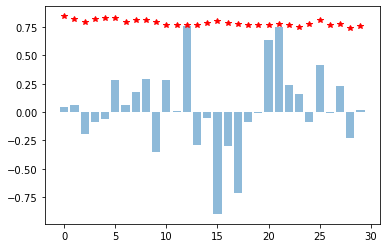

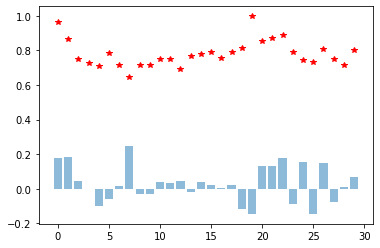

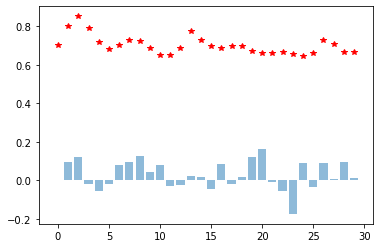

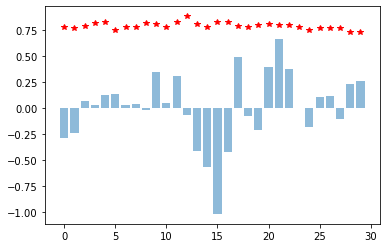

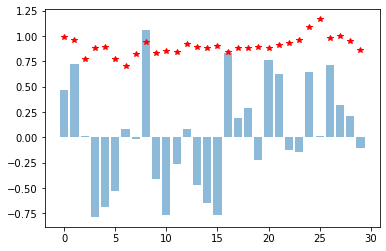

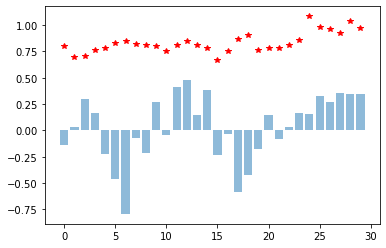

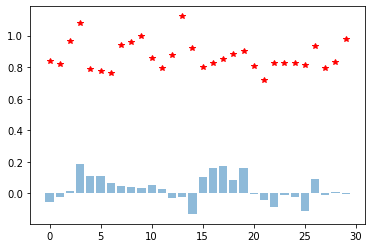

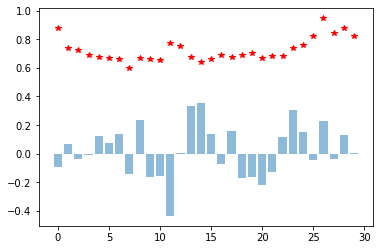

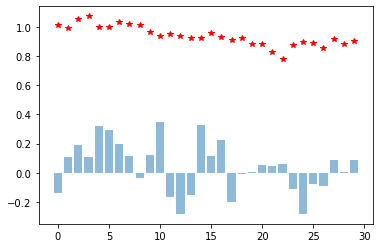

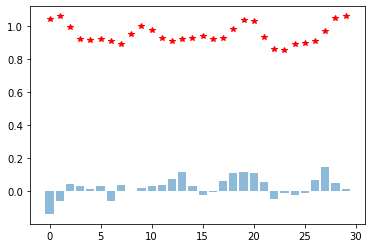

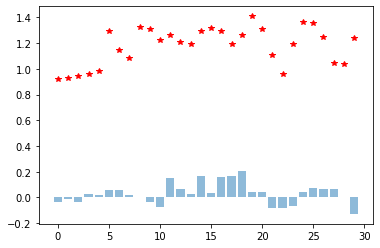

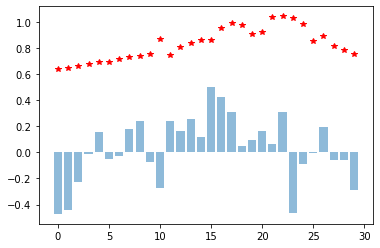

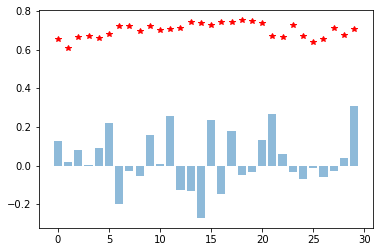

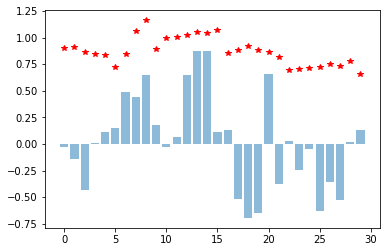

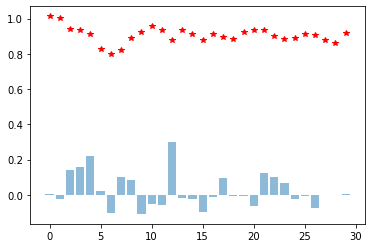

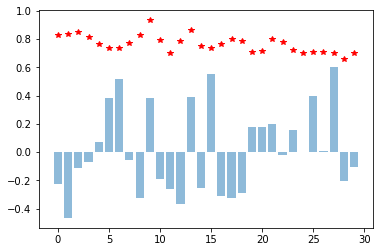

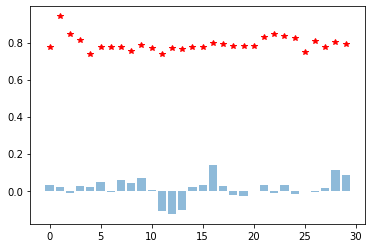

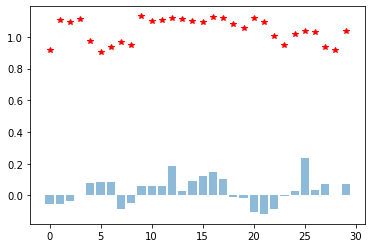

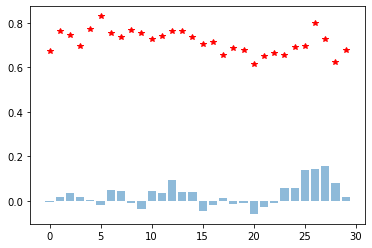

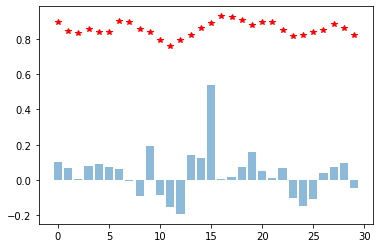

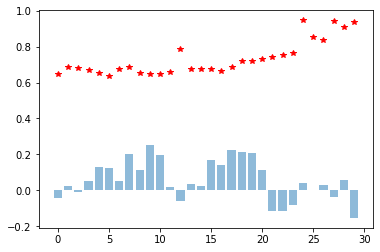

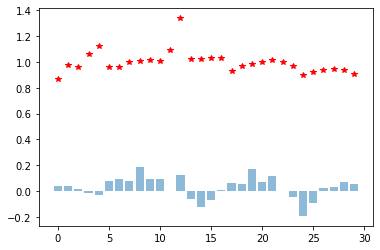

In [32]:
%matplotlib inline
for i in range(attrs.shape[0]):
    plt.figure()
    plt.plot(test_x[i],'r*',linewidth=4)
    plt.bar(np.arange(30),attrs[i],alpha=.5)
    plt.show()

In [ ]:
i = 3
x_i = x_test_sample[i]
attrs_i = attrs[i]
pred = predictions[i]
pred_dict = {1: 'Positive review', 0: 'Negative review'}

print('Predicted label =  {}: {}'.format(pred, pred_dict[pred]))

from IPython.display import HTML
def  hlstr(string, color='white'):
    """
    Return HTML markup highlighting text with the desired color.
    """
    return f"<mark style=background-color:{color}>{string} </mark>"

def colorize(attrs, cmap='PiYG'):
    """
    Compute hex colors based on the attributions for a single instance.
    Uses a diverging colorscale by default and normalizes and scales
    the colormap so that colors are consistent with the attributions.
    """
    import matplotlib as mpl
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    # now compute hex values of colors
    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

words = decode_sentence(x_i, reverse_index).split()
colors = colorize(attrs_i)

HTML("".join(list(map(hlstr, words, colors))))